# **PROJECT : Santander Customer Satisfaction**




After performing Exploratory Data Analysis in the EDA.ipynb notebook, we pickle the final train and test dataset. 
In this Notebook we perform modelling and intepret them to get better predictions. 

# Import Libraries


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
#Import libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from matplotlib import colors
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
%matplotlib inline

In [43]:
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as PImage

# Get the train and test pickle files

In [ ]:
with open('/content/drive/MyDrive/ML_2/Project_Santander/Data_pickle_files/Train_data_pickle_final.pkl', 'rb') as f:
  df_train = pickle.load(f)

In [44]:
df_train

,var3,var15,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26,ind_var30_0,ind_var30,ind_var37_cte,ind_var37,ind_var39_0,num_var4,num_var5_0,num_var12_0,num_var13_largo_0,num_var14_0,num_var26,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_var30_0,num_var30,num_var37,...,imp_var43_emit_ult1,imp_trans_var37_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var39_vig_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,var38,TARGET
0,2,26,0.00,0.00,0.00,0.00,0.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,3.00,2.13,3.00,2.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48653.31,0
1,2,23,0.00,0.00,0.00,0.00,0.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,90.00,34.83,90.00,71.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.98,0
2,2,29,0.00,0.00,0.00,210.00,0.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,2,3,0,0,0,0,3,0,0,3,3,3,0,...,0.0,0.00,0,0,0,0,0,0,3,0,9,0,9,3,15,3,0,2,0,0,0,3,0,0,0,15,15,1821.99,465.54,2465.82,1584.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42263.22,0
3,2,30,0.00,0.00,0.00,0.00,0.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,3.00,0.63,3.00,2.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59594.97,0
4,2,27,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,3,0,0,0,0,0,0,0,0,3,0,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102219,2,78,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,295043.75,1
102220,2,48,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,2,0,...,0.0,0.00,0,0,0,0,0,0,0,7,7,0,15,4,0,1,0,0,0,0,0,0,0,0,0,0,0,3.37,0.00,4.92,4.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86366.86,1
102221,2,23,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,0,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.98,1
102222,2,26,0.00,0.00,0.00,0.00,0.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,3.00,1.33,3.00,2.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68953.89,1


While reading the data, the float numbers have decimal point to 6 digits which is not appropriate for modelling ( Error: ValueError: Input contains NaN, infinity or a value too large for dtype('float64') ).

We will rounding the float values to 2 decimal points. 

In [45]:
df_train= df_train.round(decimals=2)

In [ ]:
df_train

,var3,var15,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26,ind_var30_0,ind_var30,ind_var37_cte,ind_var37,ind_var39_0,num_var4,num_var5_0,num_var12_0,num_var13_largo_0,num_var14_0,num_var26,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_var30_0,num_var30,num_var37,...,imp_var43_emit_ult1,imp_trans_var37_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var39_vig_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,var38,TARGET
0,2,26,0.00,0.00,0.00,0.00,0.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,3.00,2.13,3.00,2.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48653.31,0
1,2,23,0.00,0.00,0.00,0.00,0.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,90.00,34.83,90.00,71.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.98,0
2,2,29,0.00,0.00,0.00,210.00,0.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,2,3,0,0,0,0,3,0,0,3,3,3,0,...,0.0,0.00,0,0,0,0,0,0,3,0,9,0,9,3,15,3,0,2,0,0,0,3,0,0,0,15,15,1821.99,465.54,2465.82,1584.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42263.22,0
3,2,30,0.00,0.00,0.00,0.00,0.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,3.00,0.63,3.00,2.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59594.97,0
4,2,27,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,3,0,0,0,0,0,0,0,0,3,0,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102219,2,78,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,295043.75,1
102220,2,48,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,2,0,...,0.0,0.00,0,0,0,0,0,0,0,7,7,0,15,4,0,1,0,0,0,0,0,0,0,0,0,0,0,3.37,0.00,4.92,4.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86366.86,1
102221,2,23,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,0,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.98,1
102222,2,26,0.00,0.00,0.00,0.00,0.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,3.00,1.33,3.00,2.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68953.89,1


In [46]:
with open('/content/drive/MyDrive/ML_2/Project_Santander/Data_pickle_files/Test_data_pickle_final.pkl', 'rb') as f:
  df_test = pickle.load(f)

In [47]:
df_test

,var3,var15,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26,ind_var30_0,ind_var30,ind_var37_cte,ind_var37,ind_var39_0,num_var4,num_var5_0,num_var12_0,num_var13_largo_0,num_var14_0,num_var26,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_var30_0,num_var30,num_var37,...,imp_var43_emit_ult1,imp_trans_var37_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var39_vig_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,var38,TARGET
72608,2,24,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,3.0,1.17,3.0,2.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53471.580000,0
29169,2,69,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,3,3,0,6,0,0,3,0,2,0,0,0,0,0,0,0,0,3,150.0,90.03,150.0,130.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66008.910000,0
17189,5,39,541.29,1750.41,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.0,1,1,0,0,1800,0,0,0,9,0,9,3,18,0,0,2,12,30,0,0,0,0,0,36,9,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
42631,2,34,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,2774.37,7059.0,0,0,1,1,0,0,0,0,6,9,15,3,6,3,0,2,0,0,0,0,3,3,0,3,9,15.0,6.00,4877.4,1632.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92581.620000,0
55203,2,24,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,3.0,1.68,3.0,2.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5439,2,26,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,90.0,5.82,90.0,61.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
47385,2,37,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,6.0,3.09,6.0,5.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112935.750000,0
40051,2,62,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,90.0,24.03,90.0,68.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
49131,2,22,0.00,0.00,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,0,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77022.120000,0


Rounding off float values in test data to 2 decimal points.

In [48]:
df_test= df_test.round(decimals=2)

In [49]:
df_test

,var3,var15,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26,ind_var30_0,ind_var30,ind_var37_cte,ind_var37,ind_var39_0,num_var4,num_var5_0,num_var12_0,num_var13_largo_0,num_var14_0,num_var26,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_var30_0,num_var30,num_var37,...,imp_var43_emit_ult1,imp_trans_var37_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var39_vig_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,var38,TARGET
72608,2,24,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,3.0,1.17,3.0,2.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53471.58,0
29169,2,69,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,3,3,0,6,0,0,3,0,2,0,0,0,0,0,0,0,0,3,150.0,90.03,150.0,130.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66008.91,0
17189,5,39,541.29,1750.41,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.0,1,1,0,0,1800,0,0,0,9,0,9,3,18,0,0,2,12,30,0,0,0,0,0,36,9,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.98,0
42631,2,34,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,2774.37,7059.0,0,0,1,1,0,0,0,0,6,9,15,3,6,3,0,2,0,0,0,0,3,3,0,3,9,15.0,6.00,4877.4,1632.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92581.62,0
55203,2,24,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,3.0,1.68,3.0,2.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5439,2,26,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,90.0,5.82,90.0,61.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.98,0
47385,2,37,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,6.0,3.09,6.0,5.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112935.75,0
40051,2,62,0.00,0.00,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,3,0,0,0,0,0,0,0,0,3,3,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,90.0,24.03,90.0,68.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.98,0
49131,2,22,0.00,0.00,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,0,0,...,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77022.12,0


In [50]:
Xtest = df_test.drop('TARGET', axis =1)
ytest = df_test.TARGET

Xtrain= df_train.drop('TARGET', axis=1)
ytrain= df_train.TARGET

In [51]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((102224, 92), (102224,), (22806, 92), (22806,))

# Modelling

The performance metric we will be considering is AUC. This is a binary classification problem i.e, classify either is customer is satisfied with the services or not satisfied. Customers who are unsatisfied are huge part of the retention program. 

The retention program cost $10 for each customer and an effective loss for losing Customer (in really unsatisfied customers) of 1000. Even if we send retention program, only a percentage will accept it.
In the classification task we can have the following scenarios:



1. False Positive(FP): classify the customer as UNSATISFIED but he is SATISFIED. Cost: 10
2. False Negative(FN): classify the customer as SATISFIED but he is DISSATISFIED. Cost: 1000
3. True Positive(TP): classify the customer as UNSATISFIED and he is UNSATISFIED. f*10 + (1.-f)*(10+1000)
4. True Negative(TN): classify the customer as SATISFIED and he is SATISFIED. Cost: $ 0.



In [127]:
retention_program_cost =10
f= 0.5 # After sending out the promos, say only f are satisfied with your services
losing_customer_value = 1000
earn = -100
tnc = 0.
fpc = retention_program_cost
fnc = losing_customer_value
tpc = f*(retention_program_cost) + (1.-f)*(retention_program_cost+losing_customer_value)

Create the cost matrix

In [128]:
cost_matrix=np.array([[tnc,fpc],[fnc, tpc]])
print(cost_matrix)

[[   0.   10.]
 [1000.  510.]]


The cost is defined by the below function:

In [129]:
def average_cost(y, ypred, cost):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*cost)/np.sum(c)
    return score

The accuracy metric is defined by below function:

In [55]:
def accuracy(X, y, model):
  ypred= model.predict(X)
  return accuracy_score(y,ypred)

In [56]:
rf= 42

# Baseline models

## ALL customers are unsatisfied and we send to EVERYONE.

In [57]:
ypred_all_customers_unsatisfied= np.ones(ytest.shape[0], dtype='int')

In [58]:
print(confusion_matrix(ytest, ypred_all_customers_unsatisfied))

[[    0 21900]
 [    0   906]]


In [59]:
accuracy_score(ytest, ypred_all_customers_unsatisfied)

0.039726387792686134

## NO customer is unsatisfied and we send to No ONE

In [60]:
ypred_no_customer_unsatisfied = np.zeros(ytest.shape[0], dtype='int')

In [61]:
print(confusion_matrix(ytest, ypred_no_customer_unsatisfied))

[[21900     0]
 [  906     0]]


In [130]:
accuracy_score(ytest, ypred_no_customer_unsatisfied)

0.9602736122073139

Let us calculate the cost in these conditons:

1. Send to everyone

In [131]:
average_cost(ytest, ypred_all_customers_unsatisfied, cost_matrix)

29.863193896343066

2. Send to no one

In [132]:
average_cost(ytest, ypred_no_customer_unsatisfied, cost_matrix)

39.72638779268613

Clearly, assuming that all are satisfied costs us more than assuming that everybody is unsatisfied.

## Logistic Regression Baseline

Let us create a basic Logistic Regression classification model.

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

We are standardising the data only for logistic regression. 

In [66]:
LR_model = Pipeline([('Scaler', StandardScaler()), ('clf', LogisticRegression(random_state=rf, penalty='l2'))])

Building a logisitic regression with l2 penalty, we cross validate to find the best alpha value. The scoring function to validate is roc_auc

In [67]:
LR_parameters={'clf__C':[1000, 100, 10, 1, 0.1, 0.01, 0.001]}
gs = GridSearchCV(LR_model, param_grid=LR_parameters, cv=5, n_jobs=1, scoring='roc_auc')
gs.fit(Xtrain, ytrain)
print("BEST", gs.best_params_, gs.best_score_)
best = gs.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


BEST {'clf__C': 100} 0.911539243408717


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Best alpha = 100

In [68]:
best_alpha = 100

print("Best alpha=",best_alpha)
print("Best train AUC=",roc_auc_score(ytrain, best.predict_proba(Xtrain)[:,1]))
print("Best test AUC=",roc_auc_score(ytest,  best.predict_proba(Xtest)[:,1]))

Best alpha= 0.01
Best train AUC= 0.9125395699946233
Best test AUC= 0.7584650780690878


Let compute accuracyon train and test data

In [69]:
print("Accuracy on training data using Logisitic Regression:",  accuracy(Xtrain, ytrain, best))
print("Accuracy on test data using Logisitic Regression:",  accuracy(Xtest, ytest, best))

Accuracy on training data using Logisitic Regression: 0.8351952574737831
Accuracy on test data using Logisitic Regression: 0.8013680610365693


In [70]:
confusion_matrix(ytest, best.predict(Xtest))

array([[17745,  4155],
       [  375,   531]])

In [133]:
average_cost(ytest, best.predict(Xtest), cost_matrix)

30.139436990265718

But is this the true value of the cost? 

When we are dealing with unbalanced data, we need to always keep in mind the threshold which model is predicting on. 
In the above case, threshold is always 0.5 which means the above cost is not the true value of cost induced. 


In summary, we want to minimize the rate of FP and FN as well as maximize the rate of TP. To do so, we will use the metric AUC (area under the curve) of ROC Curve (receiver operating characteristic), because it returns us the best model as well as the best threshold.

# ROC curve

In [72]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [73]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5,  proba=True, skip=0, initial = False):
    if not ax:
        ax=plt.gca()
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

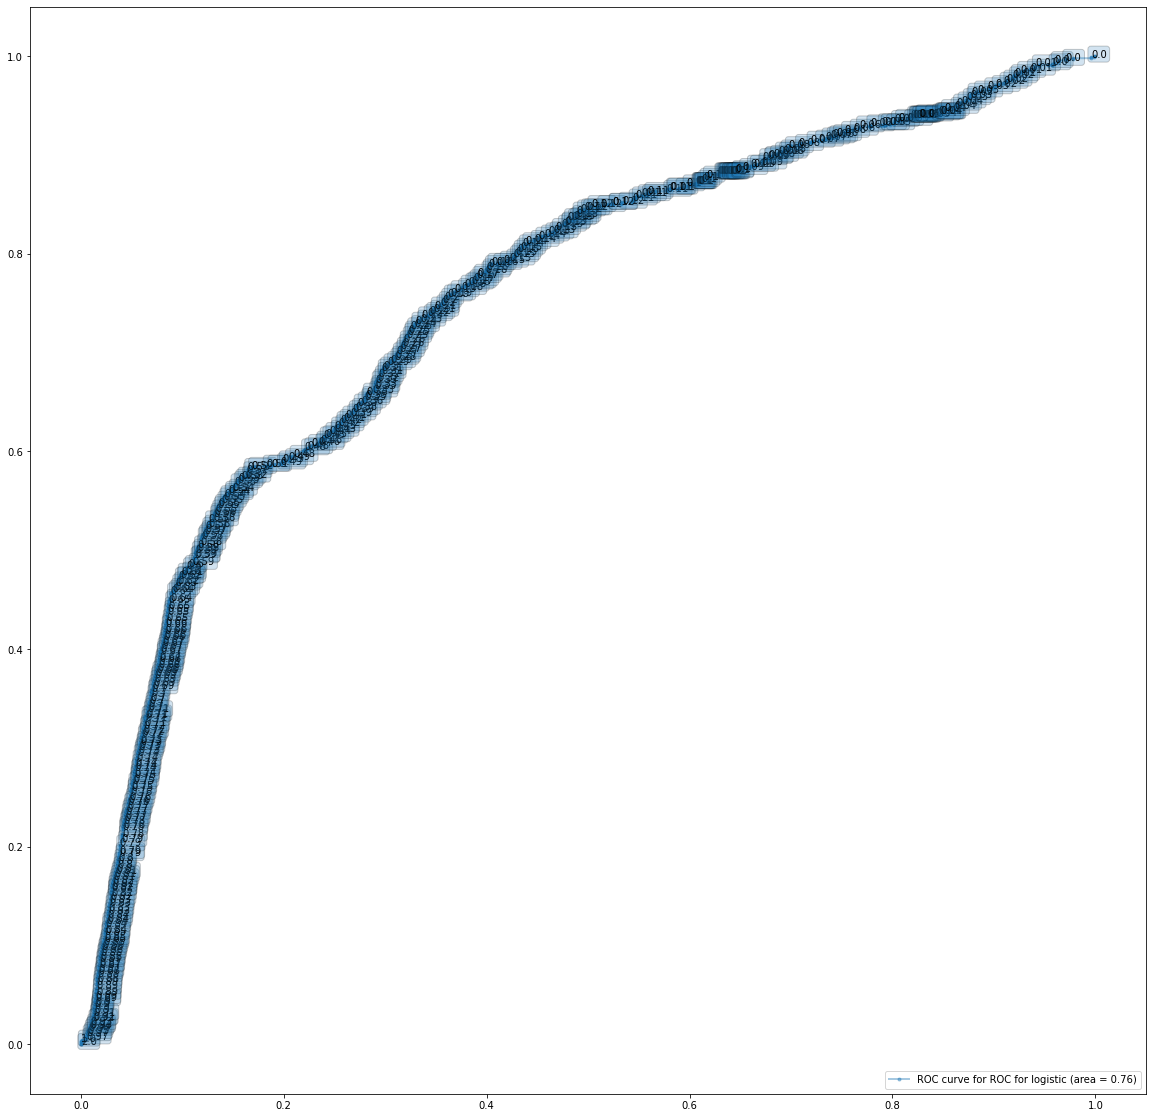

In [74]:
plt.figure(figsize=(20,20))
make_roc('ROC for logistic', best, ytest, Xtest)

Let us print the classification report to better understand the classification performance.

In [146]:
print(classification_report(ytest, best.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89     21900
           1       0.11      0.59      0.19       906

    accuracy                           0.80     22806
   macro avg       0.55      0.70      0.54     22806
weighted avg       0.94      0.80      0.86     22806



Let us plot the precision - recall curve to better understand the positive classification alone!

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

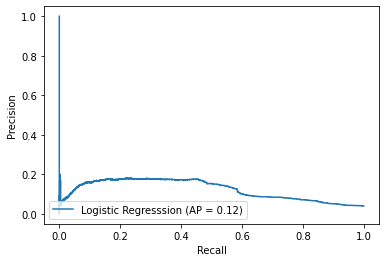

In [76]:
plot_precision_recall_curve(best, Xtest, ytest, name='Logistic Regresssion')

# Random Forest

Let us build a ensemble Random forest model with 300 trees and  finding the best model by tuning max_features and max_depth.

In [77]:
model_random_forest = RandomForestClassifier(random_state=rf, n_estimators=300)
RF_parameters ={'max_depth':[3,4,5],'max_features':range(2,10,1)}
# RF_parameters ={'max_features':range(2,10,1)}

RF_model = GridSearchCV(model_random_forest, param_grid=RF_parameters, cv=5, scoring='roc_auc')
RF_model.fit(Xtrain,ytrain)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=300, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [120]:
print(RF_model.best_params_, RF_model.best_score_)

{'max_depth': 5, 'max_features': 9} 0.9126508537274528


In [78]:
print("Accuracy on training data using Random Forest:",  accuracy(Xtrain, ytrain, RF_model))
print("Accuracy on test data using Random Forest:",  accuracy(Xtest, ytest, RF_model))

Accuracy on training data using Random Forest: 0.8136249804351229
Accuracy on test data using Random Forest: 0.7857581338244322


In [79]:
confusion_matrix(ytest, RF_model.predict(Xtest))

array([[17371,  4529],
       [  357,   549]])

In [134]:
average_cost(ytest, RF_model.predict(Xtest), cost_matrix)

29.91668859072174

Let us plot the ROC Curve for both Logistic and Random Forest

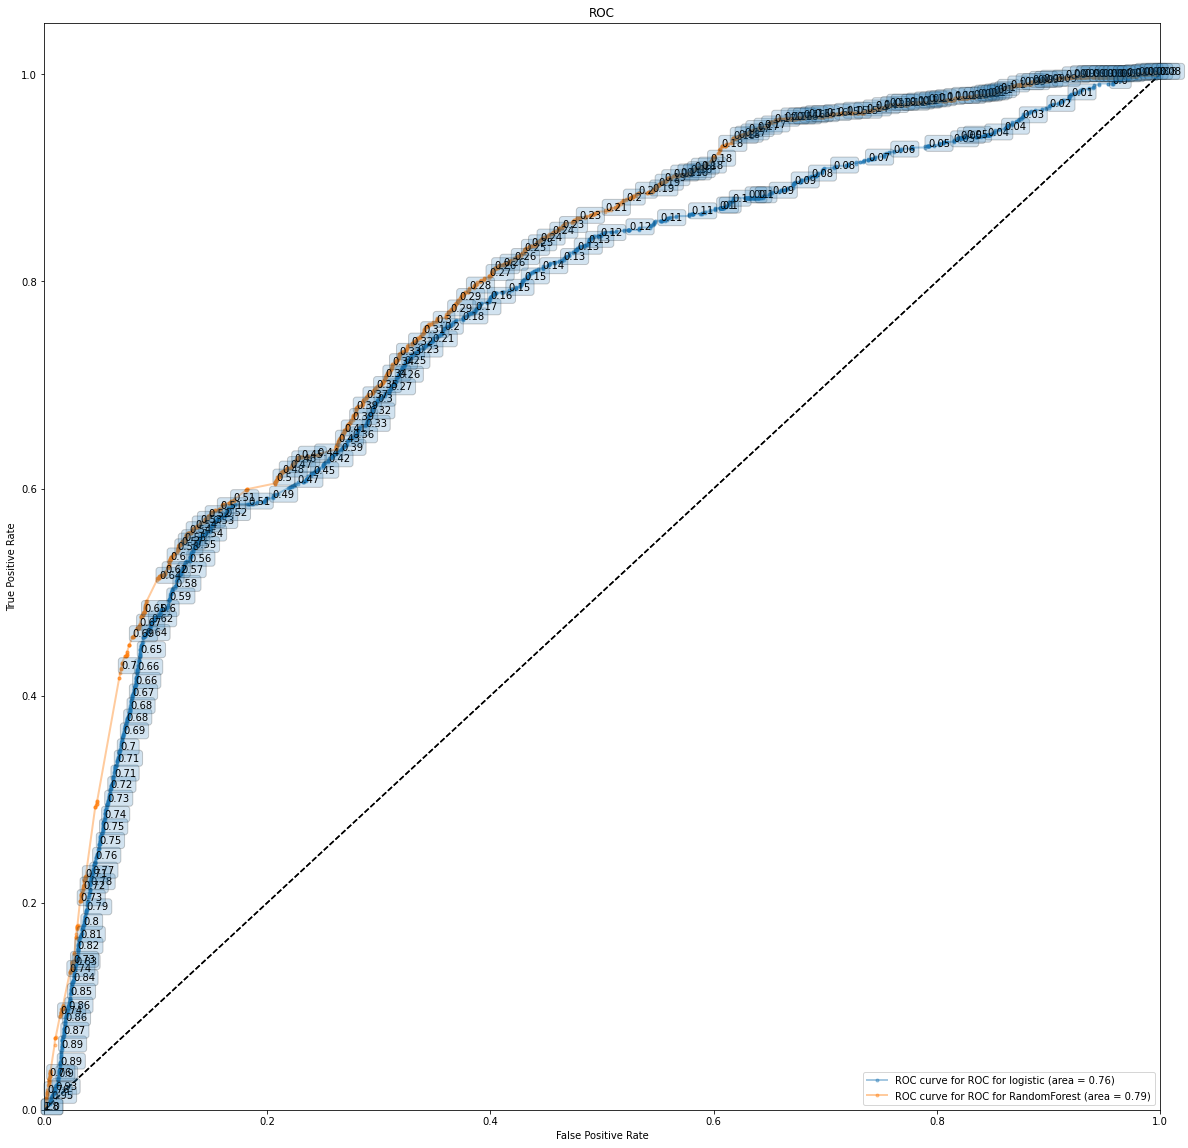

In [81]:
fig, ax = plt.subplots(figsize=(20,20))
make_roc('ROC for logistic', best, ytest, Xtest, labe=20, initial=True)
make_roc('ROC for RandomForest', RF_model, ytest, Xtest, labe=20, initial=True)

Classification report for RandomForest performance

In [82]:
print(classification_report(ytest, RF_model.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     21900
           1       0.11      0.61      0.18       906

    accuracy                           0.79     22806
   macro avg       0.54      0.70      0.53     22806
weighted avg       0.95      0.79      0.85     22806



# XGBoost Classifier

**Objective [default=reg:linear]**
This defines the loss function to be minimized. Mostly used values are:
binary:logistic –logistic regression for binary classification, returns predicted probability (not class)


**eval_metric [default according to objective]**
Evaluation metrics for validation data, a default metric will be assigned according to objective (rmse for regression, and logloss for classification, mean average precision for ranking)

**scale_pos_weight [default=1]**
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.

**subsample [default=1]**
Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
range: (0,1]


**colsample_bytree:** is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

In [89]:
from xgboost import XGBClassifier

In [90]:
tuned_param={'n_estimators':range(10,20),'learning_rate':[.05,.06,.07,.08,.09,.1,0.15,0.2,0.25,0.3]}
xgb_model=GridSearchCV(XGBClassifier(n_jobs=-1,random_state=0),param_grid=tuned_param,scoring='roc_auc',return_train_score=True)
xgb_model.fit(Xtrain, ytrain)
print("Best hyperparamters-",xgb_model.best_params_)
print("Best AUC value: ",xgb_model.best_score_ )

Best hyperparamters- {'learning_rate': 0.3, 'n_estimators': 19}
Best AUC value:  0.9545920961173534


In [92]:
pred_train_prob=xgb_model.predict_proba(Xtrain)
pred_test_prob=xgb_model.predict_proba(Xtest)
print("Train AUC=",roc_auc_score(ytrain,pred_train_prob[:,1]))
print("Test AUC=",roc_auc_score(ytest,pred_test_prob[:,1]))
pred_train=xgb_model.predict(Xtrain)
pred_test=xgb_model.predict(Xtest)

confusion_matrix(ytrain,pred_train)

Train AUC= 0.9559286150837124
Test AUC= 0.8170763655790418


array([[44899,  6213],
       [ 5271, 45841]])

In [95]:
#Performance
print("Training accuracy for XGboost Classifier :",xgb_model.score(Xtrain,ytrain))
print("Testing accuracy for XGboost Classifier:",xgb_model.score(Xtest,ytest))

Training accuracy for XGboost Classifier : 0.9559286150837124
Testing accuracy for XGboost Classifier: 0.8170763655790418


In [97]:
print(classification_report(ytest,xgb_model.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93     21900
           1       0.16      0.55      0.25       906

    accuracy                           0.87     22806
   macro avg       0.57      0.72      0.59     22806
weighted avg       0.95      0.87      0.90     22806



In [135]:
average_cost(ytest, xgb_model.predict(Xtest), cost_matrix)

30.124090151714462

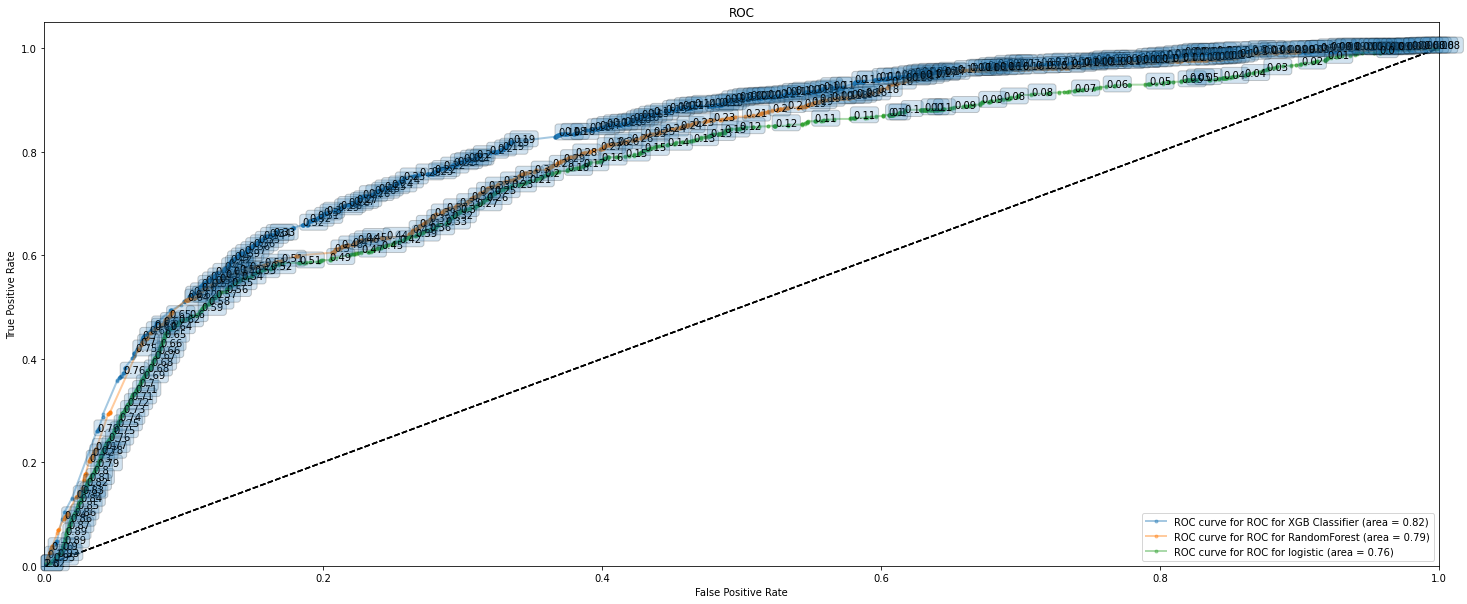

In [103]:
fig,ax = plt.subplots(figsize=(25,15))

make_roc('ROC for XGB Classifier', xgb_model, ytest, Xtest,labe=20,initial=True)
make_roc('ROC for RandomForest', RF_model, ytest, Xtest, labe=20, initial=True)
make_roc('ROC for logistic', best, ytest, Xtest, labe=20, initial=True)

As seen, AUC is high for XGBoost classifier. This means XGBoost has better performance in classifying 1 than the other two models (RandomForest and Logistic Regression)

# Feature Importance

### Permutation importance

In [114]:
def p_importance(model, cols, fi, fistd = 0):
    return pd.DataFrame({'features':cols, 'importance':fi, 'importance_std': fistd}).sort_values('importance', ascending=False).head(10)

Plot the permutation feature importance with training set

In [117]:
#finding permutation importance for XGboost Model
RF_pi=permutation_importance(RF_model,Xtrain,ytrain)

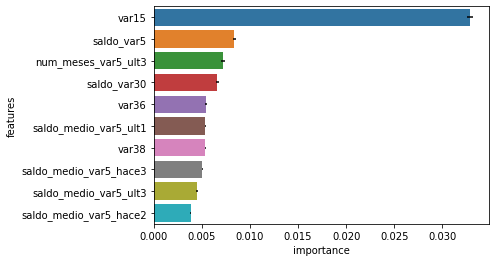

In [118]:
RF_df=p_importance(RF_model,list(Xtrain.columns),RF_pi['importances_mean'],RF_pi['importances_std'])
sns.barplot(data= RF_df, y='features',x='importance', xerr=RF_df.importance_std)

Plot the feature importance with training set

In [112]:
#Calculate permutation importance and plot a bar chart 
pfi = permutation_importance(xgb_model, Xtrain, ytrain)

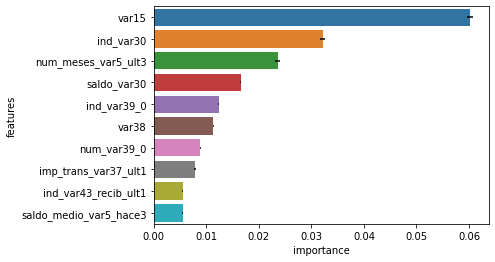

In [116]:
pfidf = p_importance(xgb_model, Xtrain.columns, pfi['importances_mean'], pfi['importances_std'])

#Plot the bar plot
sns.barplot(data= pfidf, y='features',x='importance', xerr=pfidf.importance_std)

### Partial Dependence plot

In [122]:
from sklearn.inspection import plot_partial_dependence

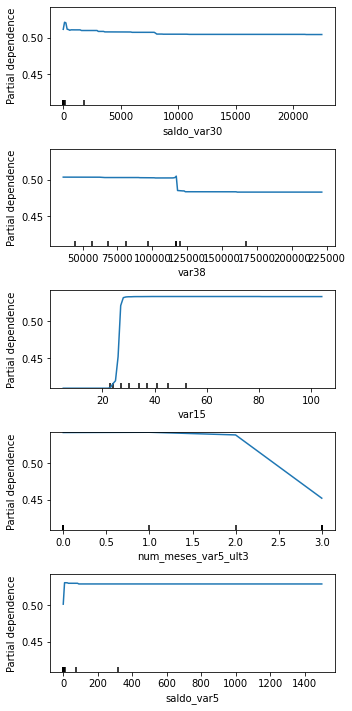

In [126]:
fig, axes = plt.subplots(5, 1, figsize = (5, 10))
#Consider the top 5 important features and graph the partial distribution plot
features=['saldo_var30', 'var38','var15','num_meses_var5_ult3','saldo_var5']
plot_partial_dependence(RF_model,Xtrain,features,grid_resolution=200,ax = axes)
fig.tight_layout()

ICE plots for better understanding the variation

In [ ]:
fig, axes = plt.subplots(5, 1, figsize = (5, 20))
#Consider the top 5 important features and graph the ICE plot
plot_partial_dependence(RF_model, Xtrain,features,kind='both',grid_resolution=200,ax = axes)
fig.tight_layout()

# Comparision of Models

In [136]:
models={'Logistic Regression': best, 'Random Forest': RF_model, 'XGBoost':xgb_model}

([0, 1, 2], <a list of 3 Text major ticklabel objects>)

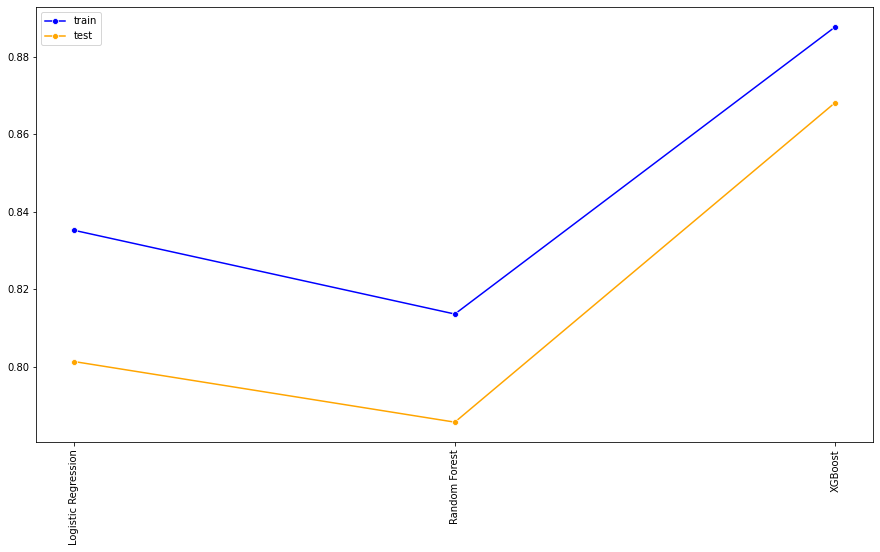

In [148]:
testing_accuracy_overall={}
training_accuracy_overall={}
training_roc_score={}
testing_roc_score={}
overfitting={}

for i,model in models.items():
  testing_accuracy_overall[i]=accuracy(Xtest, ytest, model)
  training_accuracy_overall[i]=accuracy(Xtrain, ytrain, model)
  training_roc_score[i]= roc_auc_score(ytrain, model.predict_proba(Xtrain)[:,1])
  testing_roc_score[i]= roc_auc_score(ytest, model.predict_proba(Xtest)[:,1])
  overfitting[i]= training_accuracy_overall[i]- testing_accuracy_overall[i]

fig, ax= plt.subplots(figsize=(15,8))
sns.lineplot(x= training_accuracy_overall.keys(), y = training_accuracy_overall.values(), marker='o', color='blue', label='train')
sns.lineplot(x= testing_accuracy_overall.keys(), y = testing_accuracy_overall.values(), marker='o', color='orange', label='test')
plt.xticks(rotation='90')

([0, 1, 2], <a list of 3 Text major ticklabel objects>)

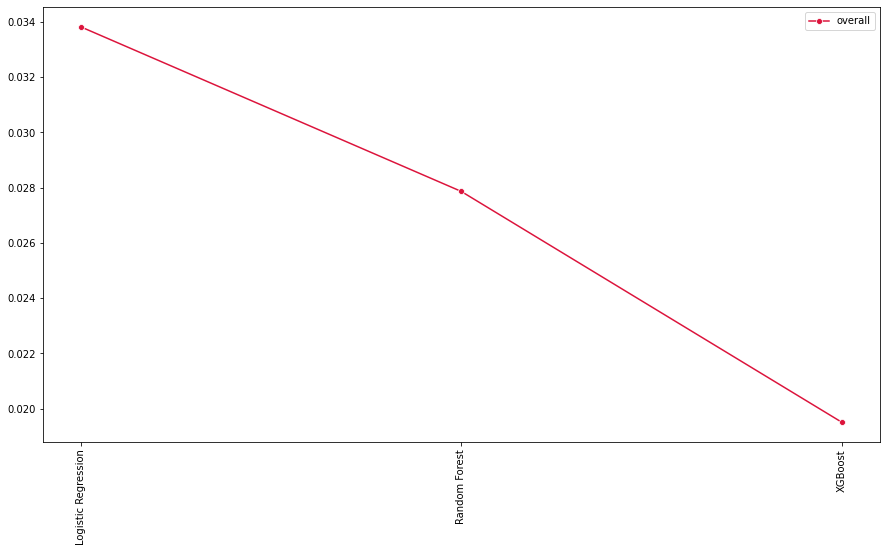

In [139]:
fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(x= overfitting.keys(), y = overfitting.values(), marker='o', color='crimson', label='overall')
plt.xticks(rotation='90')

### Cost Curves

In [142]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc
def av_cost2(tpr, fpr, cost, priorp, priorn):
    profit = priorp*(cost[1][1]*tpr+cost[1][0]*(1.-tpr))+priorn*(cost[0][0]*(1.-fpr) +cost[0][1]*fpr)
    return profit
def plot_cost(name, clf, ytest, xtest, cost, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_cost2(tpr[i], fpr[i], cost, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='cost curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

Text(0, 0.5, 'Cost')

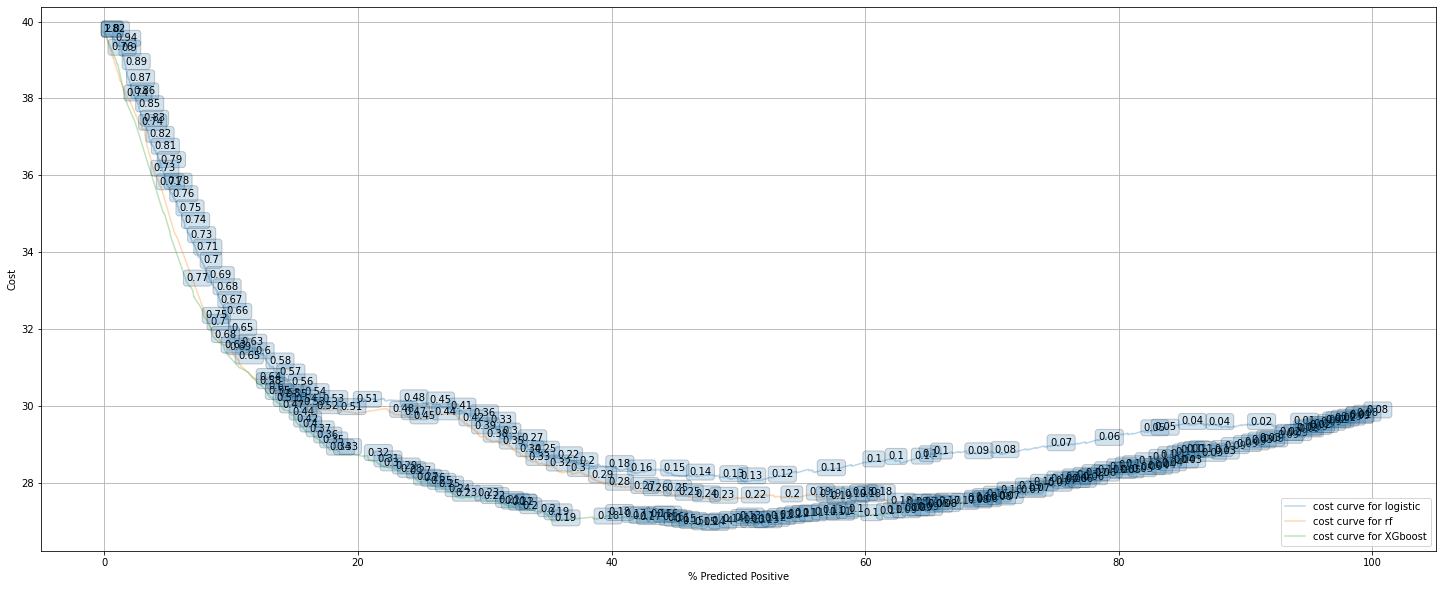

In [144]:
fig, ax = plt.subplots(figsize=(25,10))
ax = plot_cost("logistic",best, ytest, Xtest, cost_matrix, ax=ax, threshold=True, labe=30);
plot_cost("rf",RF_model, ytest, Xtest, cost_matrix, ax, threshold=True, labe=30);
plot_cost("XGboost",xgb_model, ytest, Xtest, cost_matrix, ax, threshold=True, labe=30);
ax.grid()
ax.set_xlabel('% Predicted Positive')
ax.set_ylabel('Cost')

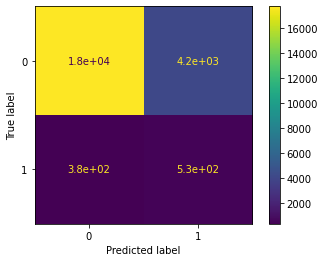

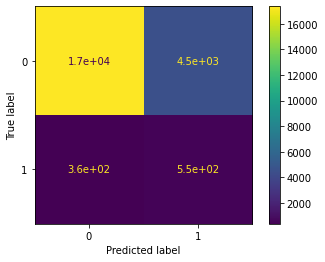

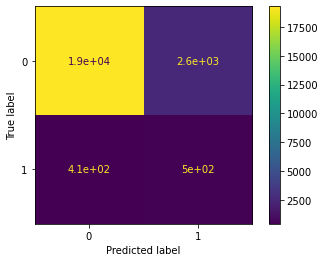

In [141]:
for i,model in models.items():
  plot_confusion_matrix(model,Xtest,ytest)

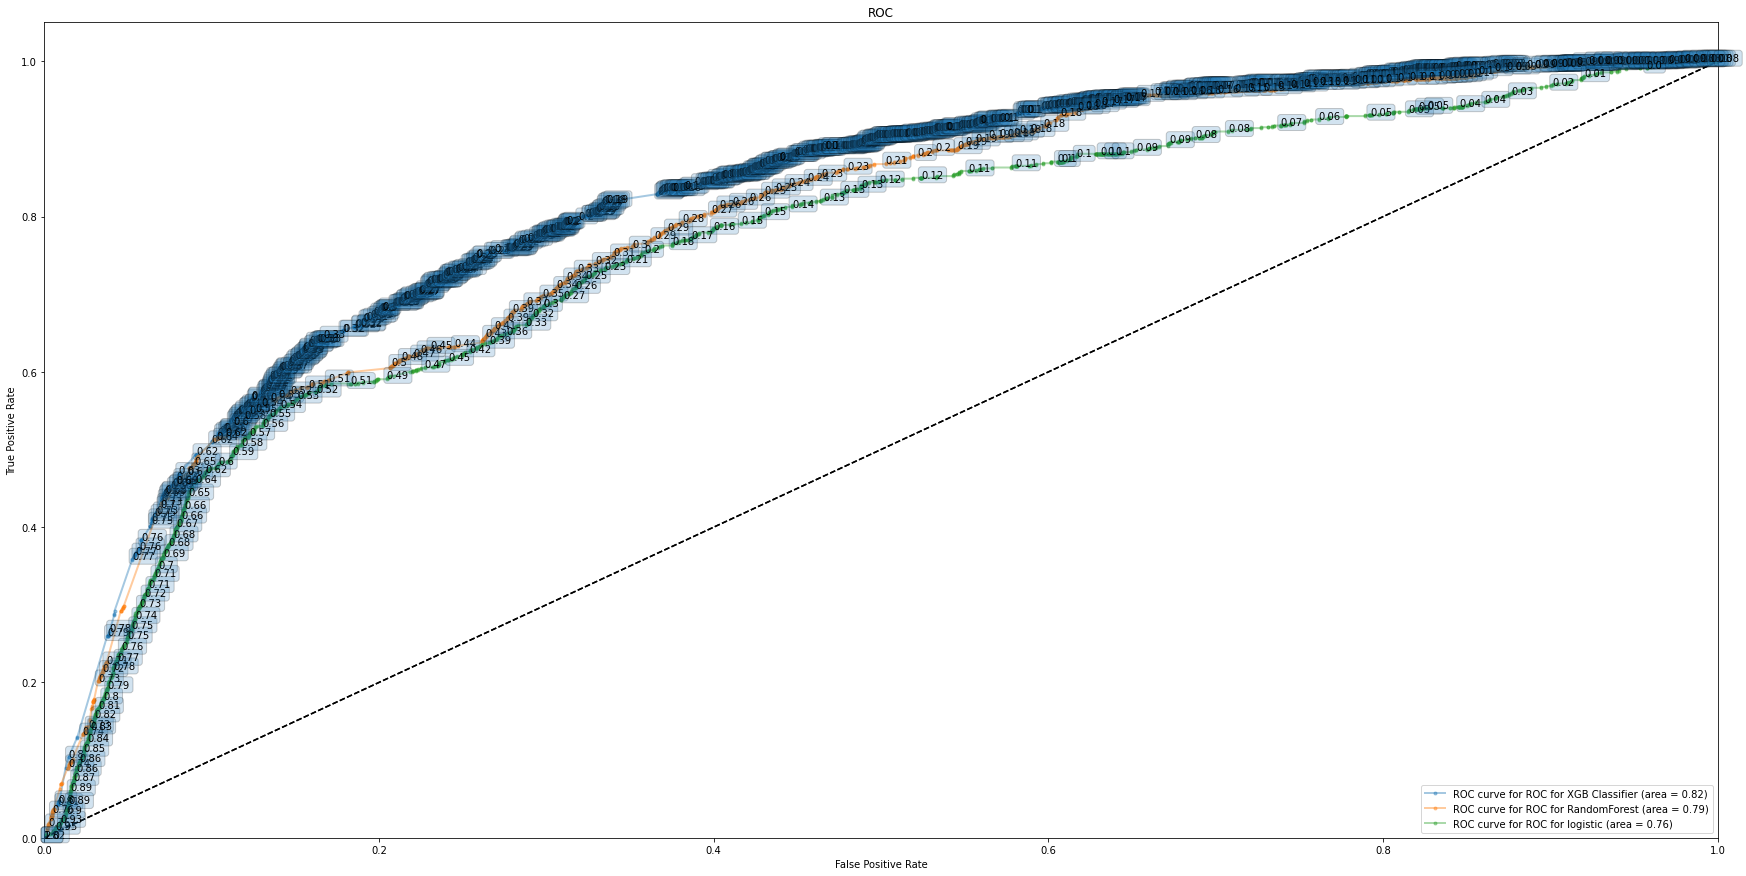

In [150]:
fig,ax = plt.subplots(figsize=(30,15))

make_roc('ROC for XGB Classifier', xgb_model, ytest, Xtest)
make_roc('ROC for RandomForest', RF_model, ytest, Xtest, labe=20, initial=True)
make_roc('ROC for logistic', best, ytest, Xtest, labe=20, initial=True)

# Conclusion

In this project, we did a study on how to preemptively understand if customers of Santander will be dissatisfied using Machine Learning. An anonymized dataset, to protect the privacy of the customers, led to difficulties in asserting what could be relevant or not, especially in light of a **huge feature set**. However a thorough data analysis discerned the meaning and interpretation of several features.

A Python implementation utilized the Logistic Regression, Random Forest and XGBoost algorithms, carefully tuned, in order to predict if the customer unsatisfied or not. 
Further research can employ different solution methods, apply more feature engineering or combine several models instead of trying singular models. More specifically they can increase the computation time that
goes into tuning and hence give better performance in classifying unsatisfied customers.